<h3><center><b>Свирин Максим Сергеевич | Б19-501 | Нейронные сети | Лаба 3 | Вариант 13</b></center></h3> 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import keras as k
from keras import backend as K
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

Классификация данных. 

$Stochastic$; $2$ $layers$: $30$ $+$ $logistic$, $5$ $+$ $logistic$;

In [123]:
def max_abs_error(true_dots, predicted_dots):
    s = []
    for x in predicted_dots:
        s.extend(x)
    return np.max(np.abs(true_dots - s))

def MSE(true_dots, predicted_dots):
    s = []
    for x in predicted_dots:
        s.extend(x)
    return np.square(np.subtract(true_dots, s)).mean()

def RMSE(true_dots, predicted_dots):
    return np.sqrt(MSE(true_dots, predicted_dots))
    
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit(x)

# x = scaler.transform(x)

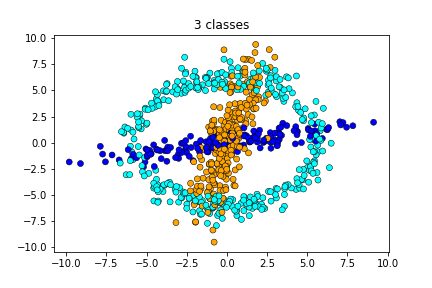

750

In [47]:
batch_size      = 20
amountOfDots    = 650
amountOfEpochs  = 100
learning_rate   = 0.01

firstLayerAmountOfNeurons  = 15
secondLayerAmountOfNeurons = 5

init_kernel_val = 1
init_bias_val   = 1
train_percent       = 0.6
validation_percent  = 0.3
test_percent        = 1 - train_percent - validation_percent

train_amount        = int(amountOfDots*train_percent)
validation_amount   = int(amountOfDots*validation_percent)
test_amount         = int(amountOfDots*test_percent)

data = pd.read_csv('./src/data_lab3v05.csv', delimiter=',', names=['x', 'y', 'class'])
dots = data.to_numpy()
amountOfDots = len(dots)
np.random.shuffle(dots)
x = dots[:, :2]

y = dots[:, 2]
y_new = tf.keras.utils.to_categorical(y-1, num_classes=3)

x_train = x[:train_amount]
x_val   = x[train_amount:train_amount+validation_amount]
x_test  = x[train_amount+validation_amount:]

y_train = y_new[:train_amount]
y_val   = y_new[train_amount:train_amount+validation_amount]
y_test  = y_new[train_amount+validation_amount:]

%matplotlib widget
plt.clf()
colors = ['aqua' if c == 1 else 'orange' if c == 2 else 'blue' for c in y]
plt.title('3 classes')
plt.scatter(x[:, 0], x[:, 1], color=colors, edgecolors='black', linewidths=0.5)
plt.savefig('./Graphs/3_classes.png', dpi=300)
plt.show()

amountOfDots

In [46]:
data['class'].value_counts()

1    350
2    250
3    150
Name: class, dtype: int64

In [81]:
kernel_initializer = tf.keras.initializers.RandomUniform(minval=-1., maxval=1., seed=None)
bias_initializer   = tf.keras.initializers.RandomUniform(minval=-1., maxval=1., seed=None)

# kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.5)
# bias_initializer   = tf.keras.initializers.RandomNormal(stddev=0.5)

inputLayer = tf.keras.layers.Input(shape=(2,))

firstHiddenLayer = tf.keras.layers.Dense(
    firstLayerAmountOfNeurons,
    activation='tanh', 
    kernel_initializer=kernel_initializer, 
    bias_initializer  =bias_initializer,
    name='First_Hidden'
)(inputLayer)

secondHiddenLayer = tf.keras.layers.Dense(
    secondLayerAmountOfNeurons,
    activation='sigmoid', 
    kernel_initializer=kernel_initializer, 
    bias_initializer  =bias_initializer,
    name='Second_Hidden'
)(firstHiddenLayer)

outputLayer = tf.keras.layers.Dense(
    3, 
    activation=tf.keras.activations.softmax,
    kernel_initializer=kernel_initializer, 
    bias_initializer  =bias_initializer,
    name='Output'
)(secondHiddenLayer)

model = k.Model(inputs=inputLayer, outputs=outputLayer)

model.compile(
    optimizer=tf.keras.optimizers.SGD(
        learning_rate=learning_rate, 
        momentum=0.9, 
        # nesterov=True
    ),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.CategoricalAccuracy()
    ]
)

# model.summary()

model.predict(x)

array([[0.18385041, 0.37070075, 0.44544885],
       [0.19881149, 0.33759043, 0.46359807],
       [0.21403804, 0.36078435, 0.4251776 ],
       ...,
       [0.20600708, 0.35958025, 0.4344127 ],
       [0.19881476, 0.32381982, 0.47736537],
       [0.24930975, 0.31235602, 0.43833426]], dtype=float32)

In [126]:
model.save('./Models/my_model_3_3.h5')

In [82]:
errors = {
    'Train':[], 
    'Validation':[], 
    'Test': [], 
    'Epoch':[]
}
values = {
    'KernelHidden': [], 
    'BiasHidden': [], 
    'ValueOut': [], 
    'Epoch': []
}

max_mae = 100
i = 1

while max_mae > 0.15:
    historyOfModel = model.fit(
        x              =x_train, 
        y              =y_train, 
        epochs         =1, 
        validation_data=(x_val, y_val),
        batch_size=batch_size
    )
    
    values['KernelHidden'].append(model.layers[0].get_weights())
    values['BiasHidden'  ].append(model.layers[0].get_weights())
    values['ValueOut'    ].append(model.layers[1].get_weights())
    values['Epoch'       ].append(i+1)
    
    errors['Train'     ].append(model.evaluate(x_train, y_train, batch_size=batch_size, verbose=0))
    errors['Validation'].append(model.evaluate(x_val, y_val,     batch_size=batch_size, verbose=0))
    errors['Test'      ].append(model.evaluate(x_test, y_test,   batch_size=batch_size, verbose=0))
    errors['Epoch'     ].append(i+1)
    i += 1
    max_mae = errors['Validation'][-1][1] if errors['Validation'][-1][1] < max_mae else max_mae

20/20 [==============================] - 0s 6ms/step - loss: 0.3096 - mean_absolute_error: 0.1454 - categorical_accuracy: 0.8538 - val_loss: 0.3511 - val_mean_absolute_error: 0.1490 - val_categorical_accuracy: 0.8154


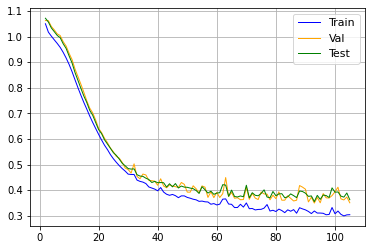

In [83]:
%matplotlib inline

plt.plot(errors['Epoch'], np.array(errors['Train'])[:, 0],      label='Train',      linewidth=1, color="blue")
plt.plot(errors['Epoch'], np.array(errors['Validation'])[:, 0], label='Val', linewidth=1, color="orange")
plt.plot(errors['Epoch'], np.array(errors['Test'])[:, 0],       label='Test',       linewidth=1, color="green")
plt.grid()

# plt.plot([37 for _ in range(2)], [i for i in range(2)], label='Retraining', linewidth=1.5, color='black')

plt.legend(fontsize=11)
plt.savefig(f'./Graphs/Loss_graph_{amountOfEpochs=}_sigmoid_{learning_rate=}_with_retraining.png', dpi=300)
plt.show()

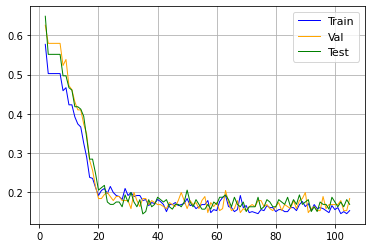

In [84]:
plt.plot(errors['Epoch'], 1 - np.array(errors['Train'])[:, 2],      label='Train',      linewidth=1, color="blue")
plt.plot(errors['Epoch'], 1 - np.array(errors['Validation'])[:, 2], label='Val', linewidth=1, color="orange")
plt.plot(errors['Epoch'], 1 - np.array(errors['Test'])[:, 2],       label='Test',       linewidth=1, color="green")

plt.legend(fontsize=11)
plt.grid()
plt.savefig(f'./Graphs/Classification_error_graph_{amountOfEpochs=}_sigmoid_{learning_rate=}.png', dpi=300)
plt.show()

In [85]:
def getErrors():
    eps_train      = 1 - np.array(errors['Train'     ])[-1, 2]
    eps_validation = 1 - np.array(errors['Validation'])[-1, 2]
    eps_test       = 1 - np.array(errors['Test'      ])[-1, 2]

    mean_loss_train      = np.mean(np.array(errors['Train'     ])[:, 0])
    mean_loss_validation = np.mean(np.array(errors['Validation'])[:, 0])
    mean_loss_test       = np.mean(np.array(errors['Test'      ])[:, 0])

    loss_train      = np.array(errors['Train'     ])[-1, 0]
    loss_validation = np.array(errors['Validation'])[-1, 0]
    loss_test       = np.array(errors['Test'      ])[-1, 0]

    return {'train': eps_train, 'valid': eps_validation, 'test.': eps_test}, {'train': loss_train, 'valid': loss_validation, 'test.': loss_test}

In [86]:
eps, mean_loss = getErrors()

for name, me in mean_loss.items():
    print(f'Loss in {name} set: \t{me}')
    
for name, e in eps.items():
    print(f'Classification error in {name} set: \t{e}')
    

Loss in train set: 	0.3044765591621399
Loss in valid set: 	0.351065456867218
Loss in test. set: 	0.363092839717865
Classification error in train set: 	0.1538461446762085
Classification error in valid set: 	0.1846153736114502
Classification error in test. set: 	0.16969698667526245


In [87]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 0.1, data[:, 0].max() + 0.1
    y_min, y_max = data[:, 1].min() - 0.1, data[:, 1].max() + 0.1
    return np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

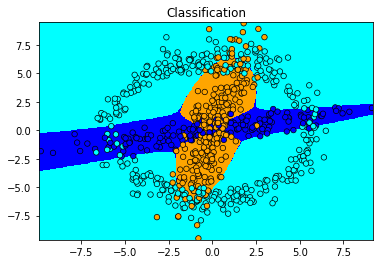

In [88]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit(x)

# x_new = scaler.transform(x)
%matplotlib inline

import matplotlib.colors as colors

XX, YY = get_grid(x)
predicted = model.predict(np.c_[XX.ravel(), YY.ravel()])
predicted = [0 if probs[0] > 0.5 else 1 if probs[1] > 0.5 else 2 for probs in predicted]
predicted = np.asarray(predicted).reshape(XX.shape)

cmap1 = colors.ListedColormap(['aqua', 'orange', 'blue'])
plt.pcolormesh(XX, YY, predicted, cmap=cmap1)
plt.scatter(x[:, 0], x[:, 1], c=y, alpha=1., s=30,
           cmap=cmap1, edgecolors='black', linewidth=0.7)

plt.title('Classification')
plt.savefig('./Graphs/Classification.png', dpi=300)
plt.show()

In [96]:
predicted_train = [0 if x[0] > 0.5 else 1 if x[1] > 0.5 else 2 for x in model.predict(x_train)]
predicted_val   = [0 if x[0] > 0.5 else 1 if x[1] > 0.5 else 2 for x in model.predict(x_val)  ]
predicted_test  = [0 if x[0] > 0.5 else 1 if x[1] > 0.5 else 2 for x in model.predict(x_test) ]


Y_train = pd.DataFrame(y_train)
Y_val   = pd.DataFrame(y_val)
Y_test  = pd.DataFrame(y_test)

print(Y_train.value_counts())
print(Y_test.value_counts())


Predicted_train = pd.DataFrame(predicted_train)
Predicted_val   = pd.DataFrame(predicted_val)
Predicted_test  = pd.DataFrame(predicted_test)

print(Predicted_train.value_counts())
print(Predicted_test.value_counts())


0    1    2  
1.0  0.0  0.0    194
0.0  1.0  0.0    119
     0.0  1.0     77
dtype: int64
0    1    2  
1.0  0.0  0.0    74
0.0  1.0  0.0    58
     0.0  1.0    33
dtype: int64
0    180
1    123
2     87
dtype: int64
0    71
1    58
2    36
dtype: int64
